In [1]:
import numpy as np
import numba as nb
from numba import types
from NumbaLSODA import lsoda, address_as_void_pointer
from matplotlib import pyplot as plt

In [2]:
# rhs function takes in two pieces of data p and arr
def rhs(t, u, du, p, arr):
    du[0] = u[0]-u[0]*u[1]*np.sum(arr)
    du[1] = u[0]*u[1]-u[1]*p

In [3]:
# use numba.types.Record.make_c_struct to build a 
# a c structure.

# 'p' is the value of p 
# 'arr_p' is the memory address of array arr
# 'len_arr' is the length of arrray arr
args_dtype = types.Record.make_c_struct([
                    ('p', types.int64),
                    ('arr_p', types.int64),
                    ('len_arr', types.int64)])

In [4]:
# this function will create the numba function to pass to lsoda.
def create_jit_rhs(rhs, args_dtype):
    jitted_rhs = nb.njit(rhs)
    @nb.cfunc(types.void(types.double,
             types.CPointer(types.double),
             types.CPointer(types.double),
             types.CPointer(args_dtype)))
    def wrapped(t, u, du, user_data_p):
        # unpack p and arr from user_data_p
        user_data = nb.carray(user_data_p, 1)
        p = user_data[0].p 
        arr = nb.carray(address_as_void_pointer(user_data[0].arr_p),(user_data[0].len_arr), dtype=np.float64)
        
        # then we call the jitted rhs function, passing in data
        jitted_rhs(t, u, du, p, arr) 
    return wrapped

In [5]:
# create the function to be called by lsoda
rhs_cfunc = create_jit_rhs(rhs, args_dtype)

In [6]:
# args = numpy array of length 1 with the custom type we specified (args_dtype)
p = 2
arr = np.ascontiguousarray(.1*np.ones(6, dtype=np.float64))
args = np.array((p,arr.ctypes.data,arr.shape[0]),dtype=args_dtype)

In [7]:
funcptr = rhs_cfunc.address
u0 = np.array([5.,0.8])
t_eval = np.linspace(0.0,50.0,1000) 
usol, success = lsoda(funcptr, u0, t_eval, data = args)

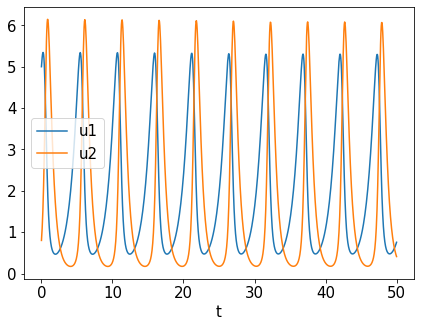

In [8]:
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[7,5])

ax.plot(t_eval,usol[:,0],label='u1')
ax.plot(t_eval,usol[:,1],label='u2')
ax.legend()
ax.set_xlabel('t')

plt.show()